# Neural Graphics Ex1: Training Your Own Diffusion Model!

## Setup environment

In [1]:
# We recommend using these utils.
# https://google.github.io/mediapy/mediapy.html
# https://einops.rocks/
!pip install mediapy einops --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.5 MB/s eta 0:00:00


In [2]:
# Import essential modules. Feel free to add whatever you need.
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Seed your work
To be able to reproduce your code, please use a random seed from this point onward.

In [3]:
def seed_everything(seed):
  torch.cuda.manual_seed(seed)
  torch.manual_seed(seed)

YOUR_SEED = 180 # modify if you want
seed_everything(YOUR_SEED)

## 1. Basic Ops and UNet blocks
**Notations:**  
 * `Conv2D(kernel_size, stride, padding)` is `nn.Conv2d()`  
 * `BN` is `nn.BatchNorm2d()`  
 * `GELU` is `nn.GELU()`  
 * `ConvTranspose2D(kernel_size, stride, padding)` is `nn.ConvTranspose2d()`  
 * `AvgPool(kernel_size)` is `nn.AvgPool2d()`  
 * `Linear` is `nn.Linear()`  
 * `N`, `C`, `W` and `H` are batch size, channels num, weight and height respectively


### Basic Ops

In [4]:
class Conv(nn.Module):
    """
    A convolutional layer that doesn’t change the image
    resolution, only the channel dimension
    Applies nn.Conv2d(3, 1, 1) followed by BN and GELU.
    """
    def __init__(self, in_channels: int, out_channels: int):
        """
        Initializes the Conv layer
        Args:
            in_channels (int): The number of input channels
            out_channels (int): The number of output channels
        """
        super().__init__()
        self.conv =nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(num_features=out_channels),
                                nn.GELU())

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, in_channels, H, W) input tensor.

        Returns:
            (N, out_channels, H, W) output tensor.
        """
        return self.conv(x)

class DownConv(nn.Module):
    """
        A convolutional layer downsamples the tensor by 2.
        The layer consists of Conv2D(3, 2, 1) followed by BN and GELU.
    """
    def __init__(self, in_channels: int, out_channels: int):
        """
        Initializes the DownConv layer
        Args:
            in_channels (int): The number of input channels
            out_channels (int): The number of output channels
        """
        super().__init__()
        self.downconv =nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                kernel_size=3, stride=2, padding=1),
                                nn.BatchNorm2d(num_features=out_channels),
                                nn.GELU())

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, in_channels, H, W) input tensor.

        Returns:
            (N, out_channels, H/2, W/2) output tensor.
        """
        return self.downconv(x)


class UpConv(nn.Module):
    """
    A convolutional layer that upsamples the tensor by 2.
    The layer consists of ConvTranspose2d(4, 2, 1) followed by
    BN and GELU.
    """
    def __init__(self, in_channels: int, out_channels: int):
        """
        Initializes the UpConv layer
        Args:
            in_channels (int): The number of input channels
            out_channels (int): The number of output channels
        """
        super().__init__()
        self.upconv =nn.Sequential(nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels,
                                kernel_size=4, stride=2, padding=1),
                                nn.BatchNorm2d(num_features=out_channels),
                                nn.GELU())


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, in_channels, H, W) input tensor.

        Returns:
            (N, out_channels, H*2, W*2) output tensor.
        """
        return self.upconv(x)


class Flatten(nn.Module):
    """
    Average pooling layer that flattens a 7x7 tensor into a 1x1 tensor.
    The layer consists of AvgPool followed by GELU.
    """
    def __init__(self):
        super().__init__()
        self.flatten = nn.Sequential(nn.AvgPool2d(kernel_size=7),
                                     nn.GELU())

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, 7, 7) input tensor.

        Returns:
            (N, C, 1, 1) output tensor.
        """
        return self.flatten(x)


class Unflatten(nn.Module):
    """
      Convolutional layer that unflattens/upsamples a 1x1 tensor into a
      7x7 tensor. The layer consists of ConvTranspose2D(7, 7, 0)
      followed by BN and GELU.
    """
    def __init__(self, in_channels: int):
        """
        Initializes Unflatten layer
        Args:
            in_channels (int): The number of input channels
        """
        super().__init__()
        self.unflatten = nn.Sequential(nn.ConvTranspose2d(in_channels=in_channels,out_channels=in_channels,
                                                          kernel_size=7, stride=7,padding=0),
                                       nn.BatchNorm2d(num_features=in_channels),
                                       nn.GELU())

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, in_channels, 1, 1) input tensor.

        Returns:
            (N, in_channels, 7, 7) output tensor.
        """
        return self.unflatten(x)

class FC(nn.Module):
    """
    Fully connected layer, consisting of nn.linear followed by GELU.
    """
    def __init__(self, in_channels: int, out_channels: int):
        """
        Initializes the FC layer
        Args:
            in_channels (int): The number of input channels
            out_channels (int): The number of output channels
        """
        super().__init__()
        self.fc =nn.Sequential(nn.Linear(in_features=in_channels, out_features=out_channels),
                               nn.GELU())

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, in_channels) input tensor.

        Returns:
            (N, out_channels) output tensor.
        """
        return self.fc(x)



### UNet Blocks

In [5]:
class ConvBlock(nn.Module):
    """
    Two consecutive Conv operations.
    Note that it has the same input and output shape as Conv.
    """
    def __init__(self, in_channels: int, out_channels: int):
        """
        Initializes ConvBlock
        Args:
            in_channels (int): The number of input channels
            out_channels (int): The number of output channels
        """
        super().__init__()
        self.convblock = nn.Sequential(Conv(in_channels, in_channels),
                                       Conv(in_channels, out_channels))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, in_channels, H, W) input tensor.

        Returns:
            (N, out_channels, H, W) output tensor.
        """
        return self.convblock(x)


class DownBlock(nn.Module):
    """
    DownConv followed by ConvBlock. Note that it has the same input and output
    shape as DownConv.
    """
    def __init__(self, in_channels: int, out_channels: int):
        """
        Initializes DownBlock
        Args:
            in_channels (int): The number of input channels
            out_channels (int): The number of output channels
        """
        super().__init__()
        self.downconv = nn.Sequential(DownConv(in_channels, out_channels),
                                      ConvBlock(out_channels, out_channels))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, in_channels, H, W) input tensor.

        Returns:
            (N, out_channels, H/2, W/2) output tensor.
        """
        return self.downconv(x)


class UpBlock(nn.Module):
    """
    UpConv followed by ConvBlock.
    Note that it has the same input and output shape as UpConv
    """
    def __init__(self, in_channels: int, out_channels: int):
        """
        Initializes UpBlock
        Args:
            in_channels (int): The number of input channels
            out_channels (int): The number of output channels
        """
        super().__init__()
        self.upconv = nn.Sequential(UpConv(in_channels, out_channels),
                                    ConvBlock(out_channels, out_channels))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, in_channels, H, W) input tensor.

        Returns:
            (N, out_channels, H*2, W*2) output tensor.
        """
        return self.upconv(x)

class FCBlock(nn.Module):
    """
    Fully-connected Block, consisting of FC layer followed by Linear layer. Note
    that it has the same input and output shape as FC.
    """
    def __init__(self, in_channels: int, out_channels: int):
        """
        Initializes FCBlock
        Args:
            in_channels (int): The number of input channels
            out_channels (int): The number of output channels
        """
        super().__init__()
        self.fcblock = nn.Sequential(FC(in_channels,out_channels),
                                     nn.Linear(out_channels,out_channels))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, in_channels) input tensor.

        Returns:
            (N, out_channels) output tensor.
        """
        return self.fcblock(x)

## 2. Unconditional Diffusion Framework


### 2.1 UNet architecture

In [6]:
class DenoisingUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_hiddens = num_hiddens
        self.ConvIn = ConvBlock(in_channels, num_hiddens)
        self.DownBlock1 = DownBlock(num_hiddens, num_hiddens)
        self.DownBlock2 = DownBlock(num_hiddens, 2*num_hiddens)
        self.Flatten = Flatten()
        self.Unflatten = Unflatten(2*num_hiddens)
        self.UpBlock1 = UpBlock(4*num_hiddens, num_hiddens)
        self.UpBlock2 = UpBlock(2*num_hiddens, num_hiddens)
        self.ConvOut = ConvBlock(2*num_hiddens, num_hiddens)
        self.Conv2D = nn.Conv2d(num_hiddens, in_channels, kernel_size=(3,3), padding=(1,1))

        # time
        self.FcBlock1 = FCBlock(1, 2*num_hiddens)
        self.FcBlock2 = FCBlock(1, num_hiddens)

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N, 1) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        # Down

        res_high = self.ConvIn(x)
        res_mid = self.DownBlock1(res_high)
        res_low = self.DownBlock2(res_mid)
        flattened = self.Flatten(res_low)

        # time in

        t_low = self.FcBlock1(t).unsqueeze(-1).unsqueeze(-1)
        t_mid = self.FcBlock2(t).unsqueeze(-1).unsqueeze(-1)

        # Up

        out = self.Unflatten(flattened) + t_low
        out = self.UpBlock1(torch.cat((res_low, out), dim=1)) + t_mid
        out = self.UpBlock2(torch.cat((res_mid, out), dim=1))
        out = self.Conv2D(self.ConvOut(torch.cat((res_high, out), dim=1)))

        return out

### 2.1 DDPM Forward and Inverse Process


In [7]:
def ddpm_schedule(beta1: float, beta2: float, num_ts: int, device: str = 'cuda') -> dict:
    """Constants for DDPM training and sampling.

    Arguments:
        beta1: float, starting beta value.
        beta2: float, ending beta value.
        num_ts: int, number of timesteps.

    Returns:
        dict with keys:
            betas: linear schedule of betas from beta1 to beta2.
            alphas: 1 - betas.
            alpha_bars: cumulative product of alphas.
    """
    assert beta1 < beta2 < 1.0, "Expect beta1 < beta2 < 1.0."

    betas = torch.linspace(beta1, beta2, num_ts).to(device)
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)

    out_dict = {
        'betas': betas,
        'alphas': alphas,
        'alpha_bars': alpha_bars,
    }
    return out_dict


In [8]:

def ddpm_forward(
    unet: DenoisingUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper (not including gradient step).

    Args:
        unet: DenoisingUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) diffusion loss.
    """
    unet.train()
    # YOUR CODE HERE.
    device = x_0.device
    N = x_0.shape[0]
    ts = torch.randint(1, num_ts+1, (N,)).to(device)
    epsilons = torch.randn(x_0.shape).to(device)
    alpha_bars = ddpm_schedule['alpha_bars'][ts-1].to(device)
    alpha_bars = alpha_bars.view(-1, 1, 1, 1)
    xt_vec = torch.sqrt(alpha_bars)*x_0 + torch.sqrt(1-alpha_bars)*epsilons
    # ts_normalized = (ts/num_ts).view(-1,1)
    # epsilons_est = unet(xt_vec,ts_normalized)
    epsilons_est = unet(xt_vec,ts)
    loss = nn.functional.mse_loss(epsilons, epsilons_est)

    return loss

In [9]:
@torch.inference_mode()
def ddpm_sample(
    unet: DenoisingUNet,
    ddpm_schedule: dict,
    img_wh: tuple[int, int],
    batch_size: int,
    num_ts: int
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper.

    Args:
        unet: DenoisingUNet
        ddpm_schedule: dict
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()
    # YOUR CODE HERE.
    device = next(unet.parameters()).device
    H, W = img_wh
    C = unet.in_channels
    xt = torch.randn(batch_size, C, H, W, device=device)

    alpha_bars = ddpm_schedule['alpha_bars']
    beta = ddpm_schedule['betas']

    for t in range(num_ts,0,-1):
        z = torch.randn_like(xt) if t > 1 else torch.zeros_like(xt)
        at = alpha_bars[t-1].view(-1, 1, 1, 1)

        t_norm = torch.full((batch_size, 1), t / num_ts, device=device)
        epsilons_est = unet(xt,t_norm)

        x0_est = (1/torch.sqrt(at))*(xt-torch.sqrt(1-at)*epsilons_est)

        at_next = alpha_bars[t-2].view(-1, 1, 1, 1) if t > 1 else torch.ones_like(at)
        bt = beta[t-1].view(-1, 1, 1, 1)

        xt = (torch.sqrt(at_next)*bt/(1-at))*x0_est + (torch.sqrt(at)*(1-at_next)/(1-at))*xt + torch.sqrt(bt)*z

    return x0_est

In [10]:
# Do Not Modify
class DDPM(nn.Module):
    def __init__(
        self,
        unet: DenoisingUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.beta_boundries = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

        for k, v in ddpm_schedule(betas[0], betas[1], num_ts).items():
            self.register_buffer(k, v, persistent=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        batch_size: int
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, img_wh, batch_size, self.num_ts
        )

### 2.3 Train your denoiser

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
from datasets import load_dataset

def load_MNIST(with_transform):
    # Init MNIST data loaders
    if not with_transform:
      transform=ToTensor()
    else:
      transfrom = transforms.Compose(
          [
              transforms.ToTensor(),
              transforms.Normalize([0.5], [0.5]),
          ]
    )

    train_data = MNIST(root='./data', train=True, download=True, transform=transfrom)
    test_data = MNIST(root='./data', train=False, download=True, transform=transfrom)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    eval_loader = DataLoader(test_data, batch_size=eval_batch_size, shuffle=True) #Not usefull now, but will be for evaluating class-conditioned denoiser (3.3)

    return train_data, test_data, train_loader, eval_loader


def postprocess(images):
    images = (images / 2 + 0.5).clamp(0, 1)
    images = images.cpu().permute(0, 2, 3, 1).numpy()
    images = (images * 255).round().astype("uint8")
    return images

In [55]:
import os
import shutil

def save_checkpoint(epoch, model, optimizer, scheduler, batch_losses, epoch_losses, CHECKPOINT_DIR):

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'batch_losses': batch_losses,
        'epoch_losses': epoch_losses,
    },  os.path.join(CHECKPOINT_DIR, f'ddpm_epoch_{epoch}.pth'))
    print(f"Checkpoint saved at epoch {epoch}")

def load_checkpoint(CHECKPOINT_DIR, train_from_scratch, num_hidden, lr, num_epochs, clear_folder):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Init denoiser and DDPM wrapper
    denosier_unet = DenoisingUNet(in_channels=1 , num_hiddens=num_hidden)
    ddpm = DDPM(denosier_unet, num_ts=T)

    # Optimizer and device setup - Adam optimizer with exponential learning rate decay
    optimizer = torch.optim.Adam(ddpm.parameters(), lr = lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma = 0.1**(1.0/num_epochs))
    ddpm.to(device)

    # Create/Clear folder if necessary
    if clear_folder and os.path.exists(CHECKPOINT_DIR):
        print(f"Clearing all checkpoints in: {CHECKPOINT_DIR}")
        # Delete the whole directory and recreate it
        shutil.rmtree(CHECKPOINT_DIR)
    if not os.path.exists(CHECKPOINT_DIR):
        os.makedirs(CHECKPOINT_DIR)
        print(f"Created directory: {CHECKPOINT_DIR}")

    # Logic to find the latest checkpoint and load it
    latest_checkpoint = None

    # Check for existing files in the directory
    if os.path.exists(CHECKPOINT_DIR):
        files = [f for f in os.listdir(CHECKPOINT_DIR) if f.endswith('.pth')]
        if files:
            # Sort by epoch number (assumes name format 'ddpm_epoch_X.pth')
            files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
            latest_checkpoint = os.path.join(CHECKPOINT_DIR, files[-1])

    if (not latest_checkpoint is None) and (not train_from_scratch):
        print(f"Loading checkpoint: {latest_checkpoint}")
        checkpoint = torch.load(latest_checkpoint)

        ddpm.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        start_epoch = checkpoint['epoch']
        batch_losses = checkpoint.get('batch_losses', [])
        epoch_losses = checkpoint.get('epoch_losses', [])
        print(f"Resuming from epoch {start_epoch}")

    else:
        start_epoch = 0
        batch_losses = []
        epoch_losses = []
        print(f"training from scratch")

    if start_epoch > num_epochs:
      raise IOError(f'The loaded model epoch was {start_epoch}, while the request number of epochs is {num_epochs}.')

    return start_epoch, ddpm, optimizer, scheduler, batch_losses, epoch_losses

In [12]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# eval setup
CHECKPOINT_DIR = "/content/drive/MyDrive/NeuralGraphicsEX1/ddpm_checkpoints"
train_from_scratch = False
clear_folder = True
eval_epochs = [1, 2, 3, 5, 10, 15, 20]
with_transform = True

# Hyper parameters - Modify if you wish
num_hidden = 128
batch_size = 64
num_epochs = 20
lr = 1e-3
img_wh = (28, 28)
eval_batch_size=20
T=1000

# initial\load checkpoint
start_epoch, ddpm, optimizer, scheduler, batch_losses, epoch_losses = load_checkpoint(CHECKPOINT_DIR, train_from_scratch, num_hidden, lr, num_epochs, clear_folder)

# Init MNIST data loaders
train_data, test_data, train_loader, eval_loader = load_MNIST(with_transform)

for epoch in tqdm(range(start_epoch, num_epochs)):
  ddpm.train()  # Set the model to training mode
  epoch_loss = 0.0
  for batch, (data, label) in enumerate(train_loader):
      optimizer.zero_grad()
      data = data.to(device)
      loss = ddpm(data)
      loss.backward()  # Compute gradients
      optimizer.step()  # Update weights
      batch_loss = loss.item()
      epoch_loss += batch_loss

      if batch % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch}/{len(train_loader)}], Loss: {batch_loss:.4f}")
        batch_losses.append(batch_loss)

  avg_epoch_loss = epoch_loss / len(train_loader)
  epoch_losses.append(epoch_loss)
  print(f"Epoch [{epoch+1}/{num_epochs}] - Average Loss: {avg_epoch_loss:.4f}")
  scheduler.step()

  ddpm.eval() # changes the behaior of BN and Dropouts layers
  # YOUR EVAL CODE HERE.
  with torch.no_grad():

      if (epoch + 1) in eval_epochs:
          print(f"Generating samples for epoch {epoch + 1}...")

          samples = ddpm.sample(img_wh=img_wh, batch_size=eval_batch_size)
          if with_transform:
            samples = postprocess(samples)

          grid = vutils.make_grid(samples, nrow=int(eval_batch_size // 4), normalize=True)
          plt.figure(figsize=(10, 10))
          plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
          plt.title(f"Samples after {epoch + 1} epochs")
          plt.axis('off')
          plt.show()

          # Recommended: Checkpoint the model as suggested in the tips

  save_checkpoint(epoch+1, ddpm, optimizer, scheduler, batch_losses, epoch_losses, CHECKPOINT_DIR)

# Final Plotting Logic
plt.figure(figsize=(12, 5))

# Plot Batch Loss
plt.subplot(1, 2, 1)
plt.plot(batch_losses, label='Batch Loss')
plt.title('Training Batch MSE Loss')
plt.xlabel('Iterations (every 100 steps)')
plt.ylabel('MSE Loss')
plt.legend()

# Plot Epoch Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, label='Epoch Loss', color='orange')
plt.title('Training Epoch Loss')
plt.xlabel('Epoch')
plt.ylabel('Total MSE Loss')
plt.legend()

plt.tight_layout()
plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')

NameError: name 'load_checkpoint' is not defined

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Step [0/938], Loss: 1.1278
Epoch [1/20], Step [100/938], Loss: 0.2434
Epoch [1/20], Step [200/938], Loss: 0.1760
Epoch [1/20], Step [300/938], Loss: 0.1355
Epoch [1/20], Step [400/938], Loss: 0.1117
Epoch [1/20], Step [500/938], Loss: 0.0897
Epoch [1/20], Step [600/938], Loss: 0.0823
Epoch [1/20], Step [700/938], Loss: 0.0937
Epoch [1/20], Step [800/938], Loss: 0.0677
Epoch [1/20], Step [900/938], Loss: 0.0617
Epoch [1/20] - Average Loss: 0.1366
Generating samples for epoch 1...


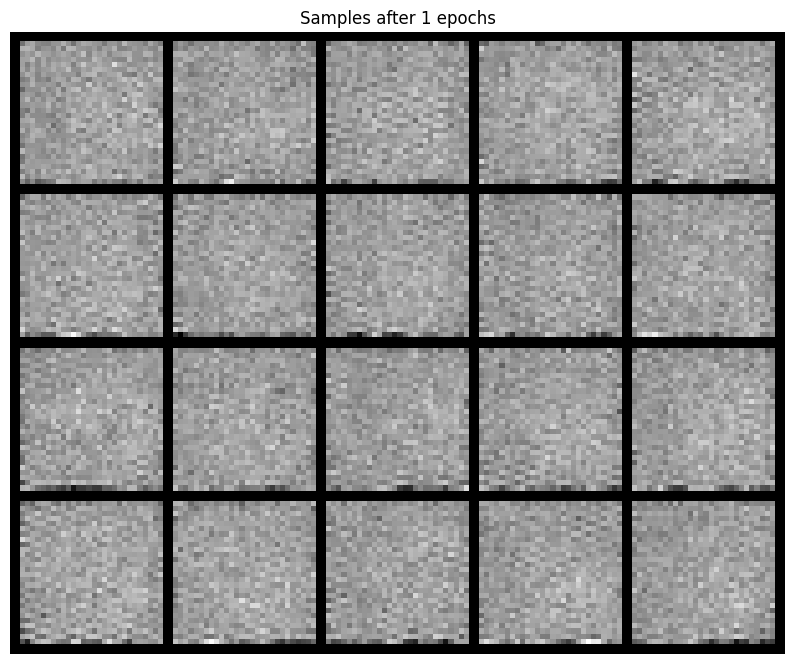

  5%|▌         | 1/20 [02:07<40:26, 127.72s/it]

Epoch [2/20], Step [0/938], Loss: 0.0717
Epoch [2/20], Step [100/938], Loss: 0.0454
Epoch [2/20], Step [200/938], Loss: 0.0446
Epoch [2/20], Step [300/938], Loss: 0.0376
Epoch [2/20], Step [400/938], Loss: 0.0389
Epoch [2/20], Step [500/938], Loss: 0.0326
Epoch [2/20], Step [600/938], Loss: 0.0224
Epoch [2/20], Step [700/938], Loss: 0.0151
Epoch [2/20], Step [800/938], Loss: 0.0239
Epoch [2/20], Step [900/938], Loss: 0.0161
Epoch [2/20] - Average Loss: 0.0376
Generating samples for epoch 2...


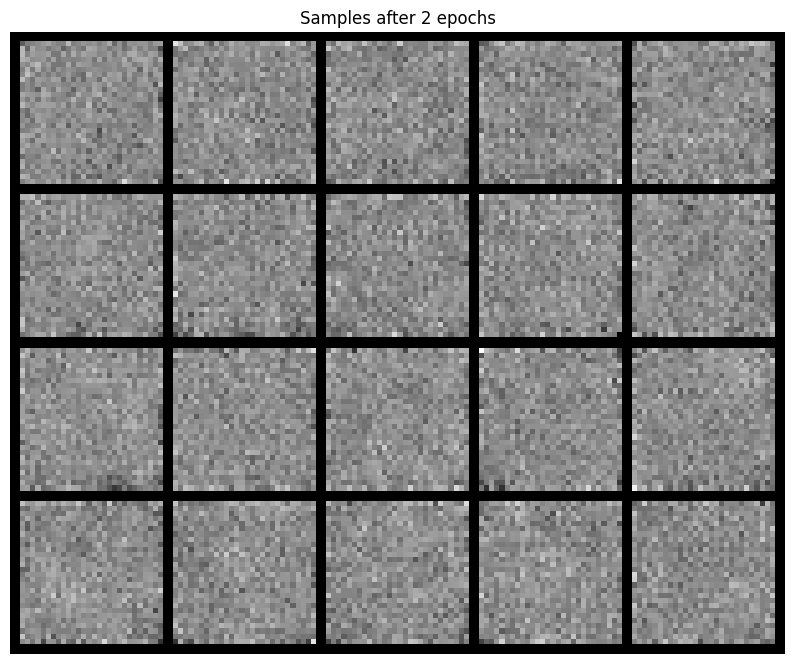

 10%|█         | 2/20 [04:14<38:14, 127.46s/it]

Epoch [3/20], Step [0/938], Loss: 0.0267
Epoch [3/20], Step [100/938], Loss: 0.0198
Epoch [3/20], Step [200/938], Loss: 0.0268
Epoch [3/20], Step [300/938], Loss: 0.0217
Epoch [3/20], Step [400/938], Loss: 0.0193
Epoch [3/20], Step [500/938], Loss: 0.0257
Epoch [3/20], Step [600/938], Loss: 0.0237
Epoch [3/20], Step [700/938], Loss: 0.0208
Epoch [3/20], Step [800/938], Loss: 0.0236
Epoch [3/20], Step [900/938], Loss: 0.0276
Epoch [3/20] - Average Loss: 0.0239
Generating samples for epoch 3...


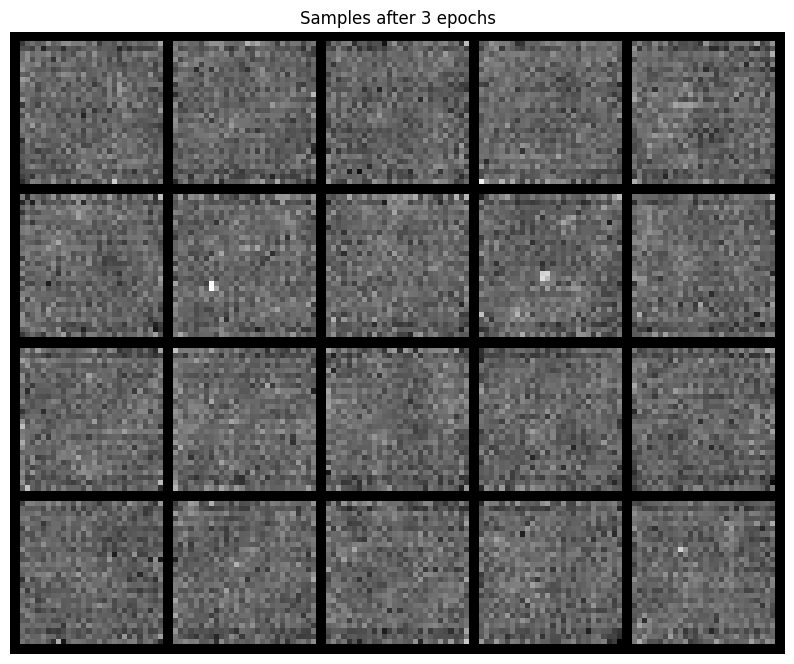

 15%|█▌        | 3/20 [06:22<36:06, 127.45s/it]

Epoch [4/20], Step [0/938], Loss: 0.0289
Epoch [4/20], Step [100/938], Loss: 0.0176
Epoch [4/20], Step [200/938], Loss: 0.0256
Epoch [4/20], Step [300/938], Loss: 0.0240
Epoch [4/20], Step [400/938], Loss: 0.0180
Epoch [4/20], Step [500/938], Loss: 0.0200
Epoch [4/20], Step [600/938], Loss: 0.0152


 15%|█▌        | 3/20 [07:40<43:30, 153.57s/it]


KeyboardInterrupt: 

In [13]:
# original training loop
import matplotlib.pyplot as plt
import torchvision.utils as vutils
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper parameters - Modify if you wish
num_hidden = 128
batch_size = 64
num_epochs = 20
lr = 1e-3
img_wh = (28, 28)
eval_batch_size=20
T=1000

# Init MNIST data loaders
train_data = MNIST(root='./data', train=True, download=True, transform=ToTensor())
test_data = MNIST(root='./data', train=False, download=True, transform=ToTensor())
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(test_data, batch_size=eval_batch_size, shuffle=True) #Not usefull now, but will be for evaluating class-conditioned denoiser (3.3)

# Init denoiser and DDPM wrapper
denosier_unet = DenoisingUNet(in_channels=1 , num_hiddens=num_hidden)
ddpm = DDPM(denosier_unet, num_ts=T)

# Optimizer and device setup - Adam optimizer with exponential learning rate decay
optimizer = torch.optim.Adam(ddpm.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma = 0.1**(1.0/num_epochs))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ddpm.to(device)

for epoch in tqdm(range(num_epochs)):
  ddpm.train()  # Set the model to training mode
  epoch_loss = 0.0
  for batch, (data, label) in enumerate(train_loader):
      optimizer.zero_grad()
      data = data.to(device)
      loss = ddpm(data)
      torch.nn.utils.clip_grad_norm_(ddpm.parameters(), 1.0)
      loss.backward()  # Compute gradients
      optimizer.step()  # Update weights
      batch_loss = loss.item()
      # YOUR CODE HERE.
      epoch_loss += batch_loss

      if batch % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch}/{len(train_loader)}], Loss: {batch_loss:.4f}")

  avg_epoch_loss = epoch_loss / len(train_loader)
  print(f"Epoch [{epoch+1}/{num_epochs}] - Average Loss: {avg_epoch_loss:.4f}")
  scheduler.step()


  ddpm.eval() # changes the behaior of BN and Dropouts layers
  # YOUR EVAL CODE HERE.
  with torch.no_grad():

    if (epoch + 1) in [1, 2, 3, 4, 5, 10, 15, 20]:
        print(f"Generating samples for epoch {epoch + 1}...")

        samples = ddpm.sample(img_wh=img_wh, batch_size=eval_batch_size)

        grid = vutils.make_grid(samples, nrow=int(eval_batch_size // 4), normalize=True)
        plt.figure(figsize=(10, 10))
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.title(f"Samples after {epoch + 1} epochs")
        plt.axis('off')
        plt.show()



## 3. Implementing class-conditioned diffusion framework with CFG


###3.1 Adding Class-Conditioning to UNet architecture

In [ ]:
class ConditionalDenoisingUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        # YOUR CODE HERE.

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N, num_classes) float condition tensor.
            t: (N, 1) normalized time tensor.
            mask: (N, 1) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        # YOUR CODE HERE.
        raise NotImplementedError()

###3.2 DDPM Forward and Inverse Process with CFG

In [ ]:
def ddpm_forward(
    unet: ConditionalDenoisingUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 3 (not including gradient step).

    Args:
        unet: ConditionalDenoisingUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        c: (N,) int64 condition tensor.
        p_uncond: float, probability of unconditioning the condition.
        num_ts: int, number of timesteps.

    Returns:
        (,) diffusion loss.
    """
    unet.train()
    # YOUR CODE HERE.
    raise NotImplementedError()

In [ ]:
@torch.inference_mode()
def ddpm_cfg_sample(
    unet: ConditionalDenoisingUNet,
    ddpm_schedule: dict,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0
) -> torch.Tensor:
    """Algorithm 4.

    Args:
        unet: ConditionalDenoisingUNet
        ddpm_schedule: dict
        c: (N,) int64 condition tensor. Only for class-conditional
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, CFG scale.

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()
    # YOUR CODE HERE.
    raise NotImplementedError()

In [ ]:
# Do Not Modify
class DDPM(nn.Module):
    def __init__(
        self,
        unet: ConditionalDenoisingUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0
    ):
        return ddpm_cfg_sample(
            self.unet, self.ddpm_schedule, c, img_wh, self.num_ts, guidance_scale
        )

###3.3 Train your class-conditioned denoiser

In [ ]:
# YOUR CODE HERE.

###3.4 Experiment with different guidance sacles

In [ ]:
# YOUR CODE HERE.
